In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as torch
import os
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
X = pd.read_pickle("X.pkl")

In [3]:
X.head

<bound method NDFrame.head of              PS1         PS2       PS3           PS4       PS5       PS6  \
0     160.673492  109.466914  1.991475  0.000000e+00  9.842170  9.728097   
1     160.603320  109.354890  1.976234  0.000000e+00  9.635142  9.529488   
2     160.347720  109.158845  1.972224  0.000000e+00  9.530548  9.427949   
3     160.188088  109.064807  1.946575  0.000000e+00  9.438827  9.337430   
4     160.000472  108.931434  1.922707  0.000000e+00  9.358762  9.260636   
5     159.920210  108.887682  1.913284  0.000000e+00  9.301160  9.206877   
6     159.672675  108.676466  1.888100  0.000000e+00  9.233942  9.143320   
7     159.614452  108.651745  1.874894  0.000000e+00  9.194159  9.105058   
8     159.475745  108.529738  1.858120  0.000000e+00  9.144616  9.057067   
9     159.437997  108.510885  1.841063  0.000000e+00  9.104831  9.019265   
10    159.321757  108.437852  1.832484  0.000000e+00  9.068217  8.983758   
11    159.235113  108.316782  1.825662  0.000000e+00  9.02

In [4]:
Y = pd.read_pickle("Y.pkl")

In [5]:
# 1 :Cooler condition / %:
# 	3: close to total failure
# 	20: reduced effifiency
# 	100: full efficiency

In [7]:
Y[0].describe()

count    2205.000000
mean       41.240816
std        42.383143
min         3.000000
25%         3.000000
50%        20.000000
75%       100.000000
max       100.000000
Name: 0, dtype: float64

In [47]:
target = pd.DataFrame(Y[0])
print(target)

        0
0       3
1       3
2       3
3       3
4       3
5       3
6       3
7       3
8       3
9       3
10      3
11      3
12      3
13      3
14      3
15      3
16      3
17      3
18      3
19      3
20      3
21      3
22      3
23      3
24      3
25      3
26      3
27      3
28      3
29      3
...   ...
2175  100
2176  100
2177  100
2178  100
2179  100
2180  100
2181  100
2182  100
2183  100
2184  100
2185  100
2186  100
2187  100
2188  100
2189  100
2190  100
2191  100
2192  100
2193  100
2194  100
2195  100
2196  100
2197  100
2198  100
2199  100
2200  100
2201  100
2202  100
2203  100
2204  100

[2205 rows x 1 columns]


In [48]:
target.loc[(target[0] == 3)] = 0
target.loc[(target[0] == 20)] = 1
target.loc[(target[0] == 100)] = 2

In [49]:
print(target)

      0
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
...  ..
2175  2
2176  2
2177  2
2178  2
2179  2
2180  2
2181  2
2182  2
2183  2
2184  2
2185  2
2186  2
2187  2
2188  2
2189  2
2190  2
2191  2
2192  2
2193  2
2194  2
2195  2
2196  2
2197  2
2198  2
2199  2
2200  2
2201  2
2202  2
2203  2
2204  2

[2205 rows x 1 columns]


In [50]:
def build_sequences(features_df, target_df, sequence_length):
    
    """
    Builds sequences from data and converts them into pytorch tensors
    sequence_length - represents the number of samples to be considered in a sequence
    
    """
    data_ = []
    target_ = []
    
    for i in range(int(features_df.shape[0]/sequence_length)):
        
        data = torch.from_numpy(features_df.iloc[i:i+sequence_length].values)
        target = torch.from_numpy(target_df.iloc[i+sequence_length+1].values)
        
        data_.append(data)
        target_.append(target)
        
    data = torch.stack(data_)
    target = torch.stack(target_)
    
    return data, target

In [51]:
sequence_length = 3

features = X
target = target
data, target = build_sequences(features, target, sequence_length=sequence_length)

print(data)
data.shape

tensor([[[160.6735, 109.4669,   1.9915,  ...,  39.6013,   1.8627,  59.1572],
         [160.6033, 109.3549,   1.9762,  ...,  25.7864,   1.2555,  59.3356],
         [160.3477, 109.1588,   1.9722,  ...,  22.2182,   1.1132,  59.5432]],

        [[160.6033, 109.3549,   1.9762,  ...,  25.7864,   1.2555,  59.3356],
         [160.3477, 109.1588,   1.9722,  ...,  22.2182,   1.1132,  59.5432],
         [160.1881, 109.0648,   1.9466,  ...,  20.4598,   1.0622,  59.7949]],

        [[160.3477, 109.1588,   1.9722,  ...,  22.2182,   1.1132,  59.5432],
         [160.1881, 109.0648,   1.9466,  ...,  20.4598,   1.0622,  59.7949],
         [160.0005, 108.9314,   1.9227,  ...,  19.7870,   1.0705,  59.4553]],

        ...,

        [[156.3950, 105.6824,   1.7380,  ...,  22.7522,   1.7663,  59.9804],
         [156.5137, 105.7913,   1.7412,  ...,  27.2730,   2.1196,  59.8352],
         [156.6206, 105.8789,   1.7347,  ...,  27.8870,   2.1560,  59.9289]],

        [[156.5137, 105.7913,   1.7412,  ...,  27.2730

torch.Size([735, 3, 17])

In [52]:
# data.transpose(1,2)
data = data.reshape(735,17,3)
print(data)

tensor([[[1.6067e+02, 1.0947e+02, 1.9915e+00],
         [0.0000e+00, 9.8422e+00, 9.7281e+00],
         [6.7098e+00, 1.0305e+01, 3.5622e+01],
         ...,
         [3.7881e+01, 4.2442e+01, 3.9632e+01],
         [3.5646e+01, 2.5199e+03, 5.7653e-01],
         [2.2218e+01, 1.1132e+00, 5.9543e+01]],

        [[1.6060e+02, 1.0935e+02, 1.9762e+00],
         [0.0000e+00, 9.6351e+00, 9.5295e+00],
         [6.7153e+00, 1.0403e+01, 3.6677e+01],
         ...,
         [3.8879e+01, 4.3404e+01, 4.0403e+01],
         [3.6579e+01, 2.5115e+03, 5.6927e-01],
         [2.0460e+01, 1.0622e+00, 5.9795e+01]],

        [[1.6035e+02, 1.0916e+02, 1.9722e+00],
         [0.0000e+00, 9.5305e+00, 9.4279e+00],
         [6.7185e+00, 1.0366e+01, 3.7881e+01],
         ...,
         [3.9804e+01, 4.4333e+01, 4.1311e+01],
         [3.7428e+01, 2.5034e+03, 5.7737e-01],
         [1.9787e+01, 1.0705e+00, 5.9455e+01]],

        ...,

        [[1.5639e+02, 1.0568e+02, 1.7380e+00],
         [0.0000e+00, 8.5014e+00, 8.4463e+00]

In [53]:
data.shape

torch.Size([735, 17, 3])

In [54]:
print(target)
target.shape

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],

        [1]])


torch.Size([735, 1])

In [74]:
# Train and test data split
test_size = 0.2

indices = torch.randperm(data.shape[0])

train_indices = indices[:int(indices.shape[0] * (1-test_size))]
test_indices = indices[int(indices.shape[0] * (1-test_size)):]

X_train, y_train = data[train_indices], target[train_indices]
X_test, y_test = data[test_indices], target[test_indices]

print(X_train)
X_train.shape

tensor([[[1.7292e+02, 1.2248e+02, 1.0827e+00],
         [0.0000e+00, 8.3934e+00, 8.3488e+00],
         [3.2903e+00, 8.9107e+00, 5.7615e+01],
         [6.0986e+01, 5.9243e+01, 5.2896e+01],
         [2.6217e+03, 7.2072e-01, 1.9169e+01],
         [1.5244e+00, 2.9909e+01, 1.7289e+02],
         [1.2246e+02, 1.0835e+00, 0.0000e+00],
         [8.3915e+00, 8.3470e+00, 3.2877e+00],
         [8.9090e+00, 5.7627e+01, 6.0993e+01],
         [5.9287e+01, 5.2964e+01, 2.6171e+03],
         [7.1813e-01, 1.9099e+01, 1.5167e+00],
         [2.9894e+01, 1.7293e+02, 1.2249e+02],
         [1.0846e+00, 0.0000e+00, 8.3920e+00],
         [8.3477e+00, 3.2818e+00, 8.9108e+00],
         [5.7634e+01, 6.1004e+01, 5.9282e+01],
         [5.2972e+01, 2.6180e+03, 7.1567e-01],
         [1.9097e+01, 1.5154e+00, 2.9785e+01]],

        [[1.7306e+02, 1.2283e+02, 1.0756e+00],
         [3.4296e-02, 8.4033e+00, 8.3598e+00],
         [3.2793e+00, 8.9357e+00, 5.7103e+01],
         [6.0267e+01, 5.8816e+01, 5.2526e+01],
         [2

torch.Size([8, 17, 3])

In [75]:
class Hydraulic_Dataset(torch.utils.data.dataset.Dataset):

    def __init__(self, data, target):
        
        self.data = data
        self.target = target
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

In [76]:
batch_size = 10

hs_train_dataset = Hydraulic_Dataset(X_train, y_train)
hs_train_loader = torch.utils.data.dataloader.DataLoader(hs_train_dataset, batch_size= batch_size)

hs_test_dataset = Hydraulic_Dataset(X_test, y_test)
hs_test_loader = torch.utils.data.dataloader.DataLoader(hs_test_dataset, batch_size= 1)

In [77]:
class Network(nn.Module):
    def __init__(self, sequence_length, n_features):
        super(Network, self).__init__()
        
        
        self.conv1 = nn.Conv1d(17, 32, kernel_size= 3)
        
        self.lin_in_size = self.conv1.out_channels * int(((sequence_length - (self.conv1.kernel_size[0]-1) -1)/self.conv1.stride[0] +1))
        print(self.lin_in_size)
        
        self.fc1 = nn.Linear(self.lin_in_size,64)
        self.fc2 = nn.Linear(64, 3)
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = x.view(-1, self.lin_in_size)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        log_probs= torch.nn.functional.log_softmax(x, dim=1)
        
        return log_probs

In [78]:
n_features = 17
print(n_features)
net = Network(sequence_length, n_features).double()
net

17
32


Network(
  (conv1): Conv1d(17, 32, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)

In [82]:
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

In [111]:
training_losses = []
training_accuracy=[]
a=[]
b=[]

for epoch in range(10):
    running_loss = 0.0
    batch_accuracy=[]
    batch_losses = []
    for i, (data, target) in enumerate(hs_train_loader):

        optimizer.zero_grad()
        out = net(data)
        loss = criterion(out, target.squeeze())
        batch_losses.append(loss.item())
        loss.backward()
        optimizer.step()    
        prediction = torch.round(out.data)   
        
# softmax = torch.exp(output).cpu()
# prob = list(softmax.numpy())
# predictions = np.argmax(prob, axis=1)
        
        
        a1=prediction.tolist()
        a2=a+a1
        a=a2
        
        b1=target.tolist()
        b2=b+b1
        b=b2
        
        
        total= 0
        correct = 0
        total += target.size(0)  
        out = torch.round(out)
        correct += (out == target).sum().item()
        accuracy = 100 * (correct / total)
        
        batch_accuracy.append(accuracy)
    training_losses.append(np.mean(batch_losses))
    training_accuracy.append(np.mean(batch_accuracy))
    print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch+1, training_losses[-1], training_accuracy[-1]))

Epoch: 1. Loss: 0.0. Accuracy: 100.0
Epoch: 2. Loss: 0.0. Accuracy: 100.0
Epoch: 3. Loss: 0.0. Accuracy: 100.0
Epoch: 4. Loss: 0.0. Accuracy: 100.0
Epoch: 5. Loss: 0.0. Accuracy: 100.0
Epoch: 6. Loss: 0.0. Accuracy: 100.0
Epoch: 7. Loss: 0.0. Accuracy: 100.0
Epoch: 8. Loss: 0.0. Accuracy: 100.0
Epoch: 9. Loss: 0.0. Accuracy: 100.0
Epoch: 10. Loss: 0.0. Accuracy: 100.0


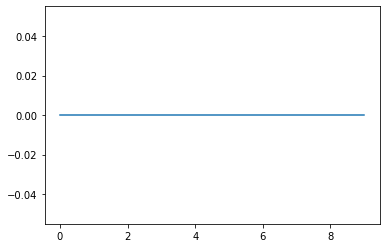

In [101]:
plt.plot(training_losses)

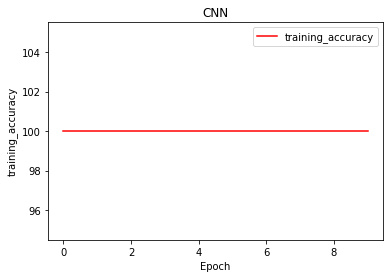

In [102]:
plt.plot(training_accuracy,'r',label = "training_accuracy")
plt.legend()
plt.title('CNN')
plt.xlabel('Epoch')
plt.ylabel('training_accuracy')
plt.show()

In [103]:
import itertools
#Creating list of all outputs and targets obtained after each epoch of training
out=list(itertools.chain.from_iterable(a2))
target=list(itertools.chain.from_iterable(b2))

In [104]:
#Calculation of classification matrix for training
#Creation of classification report for training
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
results = confusion_matrix(target, out) 
print ('CNN sigmoid Training Confusion Matrix :')
print(results) 
print ('CNN sigmoid Training Accuracy Score :',accuracy_score(target, out) )
print ('CNN sigmoid Training Report : ')
print (classification_report(target, out))

ValueError: Found input variables with inconsistent numbers of samples: [80, 240]

In [105]:
#Defining a function for graphical respresentation of confusion matrix for training 

def plot_confusion_matrix(cm, classes, normalize =False, title = "Confusion Matrix" ):
    print ("Confusion matrix")
    
    print (cm)
    plt.imshow(cm, interpolation='nearest', cmap="Blues")
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(-0.5,len(classes),1)
    plt.xticks(tick_marks, (classes))
    plt.yticks(tick_marks, (classes))
    fmt = "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [106]:
#Graphical respresentation of confusion matrix for training

classes = ['0','1']
plt.figure(figsize=(8,8))
plot_confusion_matrix(results, classes)

NameError: name 'results' is not defined

<Figure size 576x576 with 0 Axes>

In [108]:
targets = []
outputs = []

testing_loss = []
batch_loss = []

testing_accuracy = []
test_batch_accuracy=[]

a_1=[]
b_1=[]


with torch.no_grad():
    for i, (data, target) in enumerate(hs_test_loader):

        out = net(data)
        loss = criterion(out, target.squeeze())
        targets.append(target.item())
        outputs.append(out.item())
        batch_loss.append(loss.item())
        print('Target : {:.4f}, Predicted Output : {:.4f}'.format(target.item(), out.item()))
        prediction = torch.round(out.data)
    
        a3=prediction.tolist()
        a4=a_1+a3
        a_1=a4
        
        b3=target.tolist()
        b4=b_1+b3
        b_1=b4
        
        
        total= 0
        correct = 0
        total += target.size(0)
        out = torch.round(out)
        correct += (out == target).sum().item()
        accuracy = 100 * (correct / total)
              
    test_batch_accuracy.append(accuracy)
    #mean of loss of all batches => Testing loss        
    testing_loss.append(np.mean(batch_loss))
    # mean accuracy of all batches => Testing accuracy  
    testing_accuracy.append(np.mean(batch_accuracy))
    
print('Loss: {}. Accuracy: {}'.format(testing_loss[-1], testing_accuracy[-1]))

IndexError: dimension specified as 0 but tensor has no dimensions

In [ ]:
plt.plot(testing_accuracy,'b',label = "testing_accuracy")
plt.legend()
plt.title('CNN')
plt.ylabel('testing_accuracy')
plt.show()

In [ ]:
#Creating list of all outputs and targets obtained after testing
predicted1=list(itertools.chain.from_iterable(a4))
targets1=list(itertools.chain.from_iterable(b4))

#Calculation of classification matrix for testing
#Creation of classification report for testing
results1 = confusion_matrix(targets1, predicted1) 
print ('Confusion Matrix :')
print(results1) 
print ('Accuracy Score :',accuracy_score(targets1, predicted1) )
print ('Report : ')
print (classification_report(targets1, predicted1) )

In [ ]:
#Graphical respresentation of confusion matrix for testing
plot_confusion_matrix(results1, classes)